# **Storytelling - Pipeline de Dados - Bot Telegram**

## **1 - Introdução**

Este projeto, parte do trabalho de conclusão do curso de Analista de Dados da **EBAC - Escola Britânica de Artes Criativas e Tecnologia** desenvolve um pipeline automatizado que integra o Telegram à AWS.

O pipeline coleta, armazena, processa e analisa mensagens, transformando dados brutos em informações estruturadas e acionáveis.

Neste documento, apresento a arquitetura do projeto, as etapas do fluxo de dados (ingestão, ETL e análise) e as principais decisões técnicas.

## **2 - Contexto**

Os chatbots tornaram-se essenciais para automação de processos, atendimento ao cliente e suporte técnico. O Telegram, com sua API flexível, permite a criação de bots que interagem automaticamente com os usuários, enviando e recebendo mensagens em tempo real.

No entanto, as mensagens trocadas nesses bots são dados transacionais, ou seja, são registradas apenas para atender a uma solicitação imediata. Esses dados não são organizados para análise.

Diferença entre Dados Transacionais e Analíticos:

* **Dados Transacionais**: Processam informações em tempo real, como responder uma mensagem no Telegram.
* **Dados Analíticos**: São organizados para consultas e análises futuras, permitindo identificar padrões e tendências.
Para transformar dados transacionais em dados analíticos, é necessário um processo de extração, transformação e armazenamento estruturado.

🎯 Exemplo prático:

Quando você conversa com alguém no Telegram, as mensagens são processadas instantaneamente – isso ocorre em um Sistema Transacional.

Se quiser analisar suas conversas após um mês, verificando quantas vezes mencionou uma palavra específica, é necessário estruturar esses dados – isso ocorre em um Sistema Analítico.

Este pipeline foi criado para coletar, transformar e analisar mensagens do Telegram, permitindo estudos sobre frequência de mensagens, padrões de conversação e tendências ao longo do tempo. A estrutura segue o conceito de ETL (Extract, Transform, Load), garantindo que os dados possam ser utilizados de forma eficiente em consultas e análises futuras.

## **3 - Arquitetura**

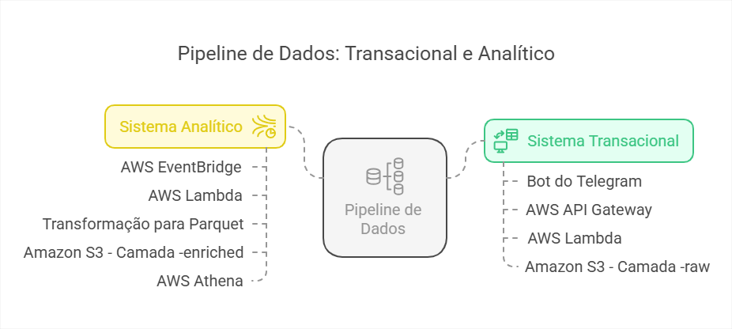

A arquitetura do pipeline foi desenvolvido para garantir um fluxo contínuo de ingestão, processamento e apresentação dos dados, utilizando serviços da AWS. Ele é dividido em dois sistemas principais:



### **3.1 Sistema Transacional - Captura e Armazenamento**

1️⃣Um bot do Telegram recebe mensagens enviadas no grupo.

In [ ]:
import json
import requests
from getpass import getpass

# Captura do token do bot de forma segura
token = getpass("Digite o token do bot: ")

# Define a URL base da API do Telegram
base_url = f'https://api.telegram.org/bot{token}'

# Função para fazer requisições e exibir respostas formatadas
def get_telegram_info(endpoint):
    response = requests.get(url=f'{base_url}/{endpoint}')
    return json.dumps(json.loads(response.text), indent=2)

# Obtendo informações sobre o bot
print("🔹 Informações do Bot:")
print(get_telegram_info("getMe"))

# Obtendo mensagens enviadas ao bot
print("\n🔹 Mensagens Recebidas:")
print(get_telegram_info("getUpdates"))

Saída esperada:

In [ ]:
# Informações do Bot:
{
  "ok": true,
  "result": {
    "id": 123456789,
    "is_bot": true,
    "first_name": "MeuBot",
    "username": "meubot_teste",
    "can_join_groups": true,
    "can_read_all_group_messages": false,
    "supports_inline_queries": false
  }
}

# Mensagens Recebidas:
{
  "ok": true,
  "result": [
    {
      "update_id": 987654321,
      "message": {
        "message_id": 1,
        "from": {
          "id": 12345678,
          "username": "usuario_exemplo",
          "first_name": "João"
        },
        "chat": {
          "id": -54321,
          "title": "Grupo do Projeto"
        },
        "text": "Olá, bot!",
        "date": 1707105600
      }
    },
    {
      "update_id": 987654322,
      "message": {
        "message_id": 2,
        "from": {
          "id": 87654321,
          "username": "maria_exemplo",
          "first_name": "Maria"
        },
        "chat": {
          "id": -54321,
          "title": "Grupo do Projeto"
        },
        "text": "Oi, bot! Como você está?",
        "date": 1707105700
      }
    }
  ]
}

2️⃣ O AWS API Gateway recebe as mensagens e aciona um AWS Lambda.

* **AWS Lambda**;

Na etapa de ingestão, o AWS Lambda tem a função de ativamente persistir as mensagens captadas pelo bot do Telegram no bucket do AWS S3.

✅ Código do Lambda para armazenar mensagens na camada -raw do S3

In [ ]:
import os
import json
import logging
import boto3
from datetime import datetime, timezone

def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")


✅Esse Lambda armazena os dados em tempo real na fase raw, garantindo que nenhuma mensagem seja perdida.

* **AWS API Gateway**

Na etapa de ingestão, o AWS API Gateway tem a função de receber as mensagens captadas pelo bot do Telegram, enviadas via webhook, e iniciar uma função do AWS Lambda, passando o conteúdo da mensagem no seu parâmetro event.

Para tanto vamos criar uma API e configurá-la como gatilho da função do AWS Lambda:


🔹Create API -> REST API;

🔹Insira um nome, como padrão, um que termine com o sufixo -api;

🔹Selecione: Actions -> Create Method -> POST;

🔹Na tela de setup:

🔹Selecione Integration type igual a Lambda Function;

🔹Habilite o Use Lambda Proxy integration;

🔹Busque pelo nome a função do AWS Lambda.

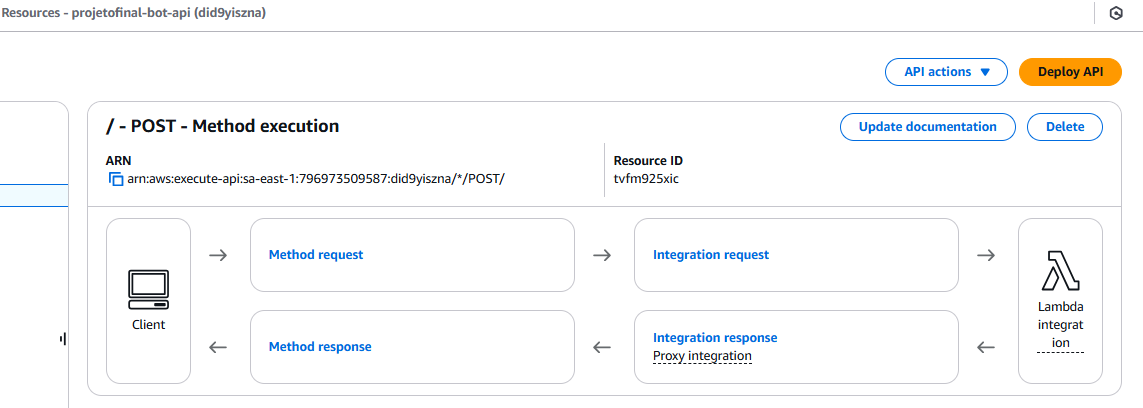

✅Fazemos a implantação da API e obtemos o seu endereço web.

Copie a url gerada na variável aws_api_gateway_url.

In [ ]:
aws_api_gateway_url = getpass()

* **Telegram**

Agora vamos configurar o webhook para redirecionar as mensagens para a url do AWS API Gateway.

In [ ]:
# O método setWebhook configura o redirecionamento das mensagens captadas pelo bot para o endereço web do paramametro url

import requests
import json

TOKEN = "SEU_TOKEN_DO_BOT"
AWS_API_GATEWAY_URL = "https://meu-api-id.execute-api.us-east-1.amazonaws.com/webhook"

BASE_URL = f"https://api.telegram.org/bot{TOKEN}"

response = requests.get(url=f"{BASE_URL}/setWebhook?url={AWS_API_GATEWAY_URL}")

print(json.dumps(json.loads(response.text), indent=2))


✅ Exemplo de payload recebido via API Gateway (formato JSON):


In [ ]:
{
  "update_id": 987654321,
  "message": {
    "message_id": 1,
    "from": {"id": 12345678, "username": "usuario_exemplo"},
    "chat": {"id": -54321, "title": "Grupo do Projeto"},
    "text": "Essa é uma mensagem de teste!",
    "date": 1707105600
  }
}

3️⃣ Nesse momento a Lambda processa e armazena as mensagens na camada -raw do Amazon S3 em formato JSON, garantindo a integridade dos dados.

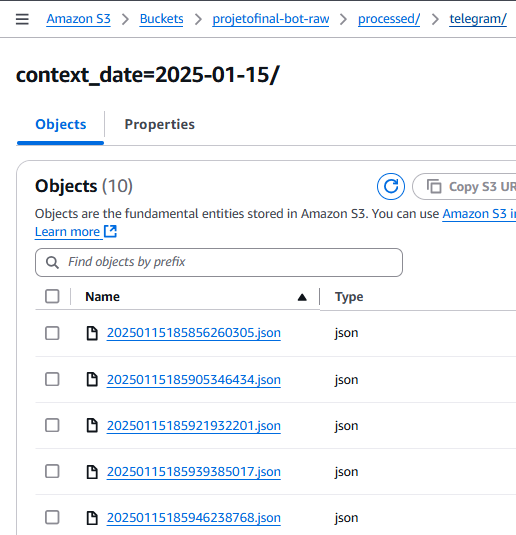

## **3.2 - Sistema Analítico - ETL e Análise**

Após a captura das mensagens, inicia-se o processo de ETL (Extração, Transformação e Carregamento), que converte os dados para um formato otimizado para análise.

Essa etapa é responsável por manipular os dados ingeridos dos sistemas transacionais, armazenando-os de forma estruturada na camada analítica.

No projeto, as mensagens de um único dia passam por um processo automatizado de data wrangling, onde os dados são limpos, deduplicados e organizados. Além disso, utilizamos técnicas de particionamento, orientação a colunas e compressão para melhorar a eficiência do armazenamento e das consultas.

Para isso, usamos uma função AWS Lambda como motor de processamento e um bucket S3 na camada enriched para armazenar os dados processados. A execução diária é garantida por uma regra do AWS EventBridge, que aciona o processo automaticamente.

1️⃣ Um AWS Lambda, acionado diariamente pelo AWS EventBridge, executa o ETL (Extract, Transform, Load).



* **AWS Lambda**:

Na etapa de ETL, o AWS Lambda tem a função de ativamente processar as mensagens captadas pelo bot do Telegram, persistidas na camada cru no bucket do AWS S3, e persisti-las na camada enriquecida, também em um bucket do AWS S3. Logo, vamos criar uma função que opera da seguinte forma:

✅Lista todos os arquivos JSON de uma única participação da camada crua de um bucket do AWS S3;

✅Para cada arquivo listado:

🔹Faz o download do arquivo e carrega o conteúdo da mensagem;

🔹Executa uma função de data wrangling;

🔹Cria uma tabela do PyArrow e a contatena com as demais.

✅Persiste a tabela no formato Parquet na camada enriquecida em um bucket do AWS S3.

**Nota**: O fato de utilizarmos duas camadas de armazenamento e processamento, permite que possamos reprocessar os dados crus de diversas maneiras, quantas vezes forem preciso.

📌 O AWS Lambda processa os arquivos JSON da camada -raw, os converte para Parquet e armazena os dados na camada -enriched do S3.

✅ Código do Lambda para converter JSON para Parquet

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

✅ O código da função de data wrangling:

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

Para que a função do AWS Lambda funcione corretamente, algumas configurações precisam ser ajustadas:

✅ Variáveis de Ambiente: É necessário definir as variáveis AWS_S3_BUCKET e AWS_S3_ENRICHED com os nomes dos buckets do S3 (camada raw e enriched). Isso pode ser feito no console do AWS Lambda, na seção Configurações → Variáveis de Ambiente.

✅ Permissões: A função Lambda precisa de permissão de escrita nos buckets do S3, que deve ser configurada no AWS IAM.

✅ Recursos: O tempo limite padrão do AWS Lambda é de 3 segundos, mas será aumentado para 5 minutos para garantir que a função consiga processar os arquivos do S3 corretamente.

✅ Camadas: Como a função usa a biblioteca PyArrow, que não está disponível no ambiente padrão do AWS Lambda, criamos uma Lambda Layer para adicioná-la. Para isso:

* Criamos um bucket no S3 para armazenar a biblioteca.

* Enviamos o pacote PyArrow para esse bucket.

* Criamos uma Layer no AWS Lambda e a vinculamos à função.


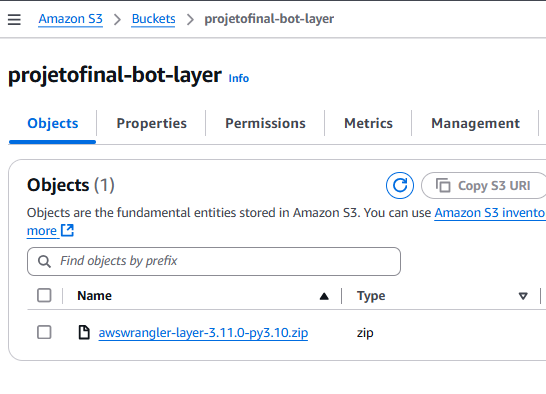

* **AWS EventBridge - Agendamento do ETL -**

Na etapa de ETL, o AWS EventBridge atua como um scheduler, programando a execução automática da função de ETL do AWS Lambda.

Para garantir o processamento diário dos dados armazenados no S3, configuramos uma Regra no AWS EventBridge que aciona a função Lambda todos os dias à meia-noite.


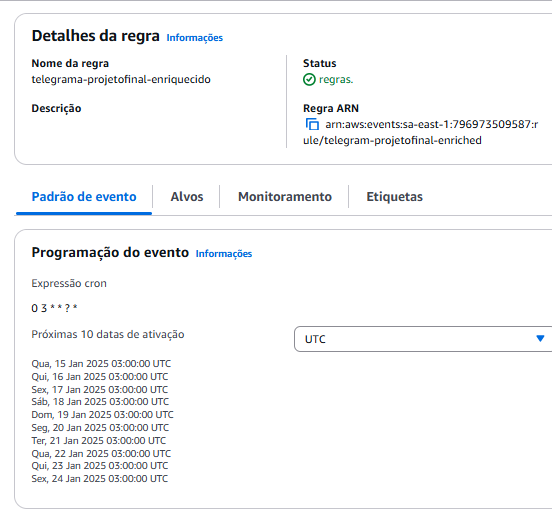

📌 Isso garante que os dados brutos sejam processados uma vez por dia e movidos para a camada enriched.

 * **AWS S3**

Na etapa de ETL, o AWS S3 armazena as mensagens processadas de um dia em um único arquivo no formato Parquet. Para isso, criamos um bucket específico, seguindo o padrão de nomenclatura com o sufixo -enriched.

Os arquivos JSON da camada -raw são transformados e armazenados no S3 -enriched, garantindo um formato mais eficiente. O Parquet melhora a performance das consultas e reduz os custos de armazenamento, tornando o processamento de dados mais rápido e otimizado.

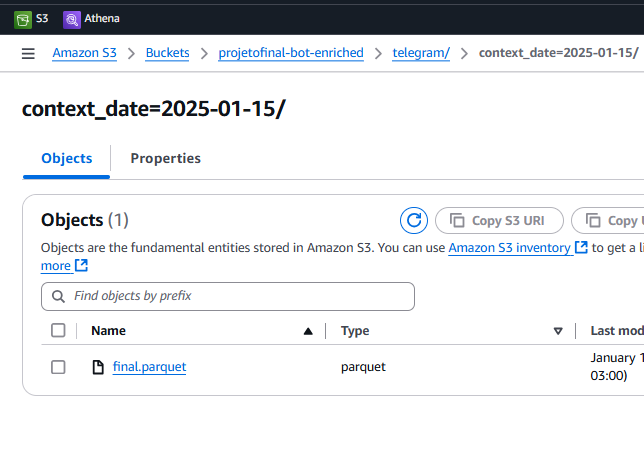

## **4 - Análise Exploratória de Dados - Apresentação**

Para entender melhor o comportamento das mensagens no grupo do Telegram, realizamos uma Análise Exploratória de Dados (EDA) no AWS Athena.

Essa é a principal etapa de acesso dos usuários, tornando essencial que os dados sejam armazenados em camadas refinadas, garantindo consultas mais eficientes e resultados mais consistentes.

### **4.1. AWS Athena**

No pipeline, o AWS Athena atua como a interface de consulta SQL para os dados processados. Para isso, criamos uma tabela externa que referencia os arquivos armazenados na camada enriquecida (enriched) do S3.

Esse processo permite que os usuários realizem consultas rápidas e econômicas, sem a necessidade de configurar um banco de dados tradicional.

1️⃣ **Criando a Tabela no AWS Athena**

A tabela será criada com base nos arquivos Parquet armazenados no S3, na camada enriched.

In [ ]:
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<bucket-enriquecido>/'

**Importante**: Toda vez que uma nova partição é adicionada ao repositório de dados, é necessário informar o AWS Athena para que a ela esteja disponível via SQL.

Para isso, use o comando SQL **MSCK REPAIR TABLE** <nome-tabela> para todas as partições.

In [ ]:
MSCK REPAIR TABLE `telegram`;

 * Após a criação, verificamos a estrutura dos dados disponíveis:

In [ ]:
DESCRIBE telegram;

✅ Isso retorna os nomes das colunas e seus tipos de dados, permitindo que entendamos quais informações podem ser extraídas.

2️⃣ **Explorando os dados**

Com o dado disponível, usuário pode executar as mais variadas consultas analíticas. Seguem alguns exemplos:

* **Podemos começar rodando um teste rápido para verificar se os dados estão acessíveis:**

In [ ]:
SELECT * FROM telegram LIMIT 10;

* **Quantidade de mensagem por dia**:

In [ ]:
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC

✅ Com essa consulta, podemos identificar os dias mais movimentados no grupo e padrões de comportamento ao longo do tempo, e ajudando a identificar picos de atividade.

* **Usuários mais ativos no grupo**

In [ ]:
SELECT user_first_name, COUNT(*) AS total_mensagens
FROM telegram
GROUP BY user_first_name
ORDER BY total_mensagens DESC
LIMIT 10;

✅ Isso nos permite identificar os membros mais participativos no grupo.

* **Número de mensagens enviadas por usuário em cada dia**

In [ ]:
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC

✅ Analisar o comportamento dos usuários ao longo do tempo.

✅ Identificar os membros mais ativos do grupo.

✅ Criar rankings diários de participação.

* **Frequência de mensagens ao longo do dia**

In [ ]:
WITH parsed_date_cte AS (
    SELECT
        *,
        from_unixtime(date) AS parsed_date,
        EXTRACT(hour FROM from_unixtime(date)) AS hora_do_dia  -- Extraindo a hora já na CTE
    FROM telegram
)
SELECT
    hora_do_dia,
    COUNT(*) AS total_mensagens
FROM parsed_date_cte
GROUP BY hora_do_dia
ORDER BY hora_do_dia;

✅ A análise do horário das mensagens enviadas no grupo do Telegram é essencial para identificar padrões de atividade ao longo do dia.

* **Analisando o Volume de Mensagens por Horário, Dia da Semana e Semana do Ano**

In [ ]:
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday

✅Com isso, podemos determinar os períodos de maior e menor atividade no grupo.

* **Atividade por Dia da Semana**

In [ ]:
WITH parsed_date_cte AS (
    SELECT
        *,
        from_unixtime(date) AS parsed_date,
        EXTRACT(dow FROM from_unixtime(date)) AS dia_da_semana  -- Obtém o dia da semana (0 = domingo, 6 = sábado)
    FROM telegram
)
SELECT
    dia_da_semana,
    COUNT(*) AS total_mensagens
FROM parsed_date_cte
GROUP BY dia_da_semana
ORDER BY dia_da_semana;

✅ Isso nos mostra quais dias da semana têm maior volume de mensagens.

* **Quais usuários enviam mais mensagens por horário**

In [ ]:
WITH parsed_date_cte AS (
    SELECT
        *,
        from_unixtime(date) AS parsed_date,
        EXTRACT(hour FROM from_unixtime(date)) AS hora_do_dia
    FROM telegram
)
SELECT
    hora_do_dia,
    user_first_name,
    COUNT(*) AS total_mensagens
FROM parsed_date_cte
GROUP BY hora_do_dia, user_first_name
ORDER BY hora_do_dia, total_mensagens DESC;



✅Isso nos mostra quais usuários são mais ativos em cada horário do dia.

# **5 - Conclusão**
Este projeto demonstrou a construção de um pipeline de dados automatizado, integrando o Telegram à AWS, permitindo a coleta, processamento e análise de mensagens enviadas em um grupo.

Através das etapas de ingestão, ETL e análise exploratória de dados, conseguimos transformar mensagens brutas em informações estruturadas, possibilitando insights valiosos sobre a atividade do grupo.

### **Principais Resultados**

* **Automação Completa do Pipeline:**

🔹Captura de Mensagens via API do Telegram:

O bot do Telegram interage com a API do Telegram, utilizando o método getUpdates para capturar mensagens enviadas no grupo.

🔹Armazenamento na Camada Raw (Bruta):

As mensagens captadas são enviadas para um endpoint HTTP gerenciado pelo AWS API Gateway.
Esse endpoint aciona um AWS Lambda, que processa as mensagens e as armazena no S3 (camada raw) no formato JSON, garantindo que nenhuma informação seja perdida.

🔹 Processamento e Transformação via ETL:

Um AWS Lambda agendado pelo AWS EventBridge executa um processo de ETL diariamente à meia-noite.
Os dados brutos em JSON são convertidos para o formato Parquet, otimizando o armazenamento e a performance das consultas.
Os dados transformados são armazenados na camada enriched do S3, prontos para análise.


* **Análises e Insights Obtidos no AWS Athena:**

🔹 Identificação dos horários mais movimentados

A análise dos dados revelou os períodos de maior atividade no grupo, possibilitando a previsão de picos de interação e a melhor gestão da comunicação.

🔹 Mapeamento dos usuários mais ativos

Com base na contagem de mensagens enviadas, conseguimos identificar quem são os principais participantes e como variam suas interações ao longo do tempo.

🔹 Distribuição das mensagens ao longo dos dias da semana e semanas do ano

Os dados foram organizados e analisados para identificar padrões sazonais, permitindo entender se há picos de interação em determinados dias ou períodos específicos do ano.a semana e semanas do ano, possibilitando padrões sazonais e tendências.


* **Potencial Visualização**:

Criamos consultas SQL que podem ser transformadas em gráficos de linha, barras e heatmaps, permitindo a análise visual dos padrões de interação no grupo.

Este pipeline serve como uma base sólida para análise de interações em grupos do Telegram, podendo ser aplicado em diversos contextos, como:

* Monitoramento de grupos de suporte ou comunidades para entender o engajamento.

* Análise de padrões de mensagens em projetos de atendimento automatizado.

* Exploração de tendências e sazonalidades em conversas online.

Com essa estrutura, abrimos caminho para análises mais profundas, tornando os dados acionáveis e estratégicos para tomada de decisão.